This notebook demonstrates data quality checks

In [2]:
!pip install -r requirements.txt -q

In [3]:
import re
import json
import os
import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import sagemaker
import tensorflow as tf
import pandas as pd
import s3fs
import random
from concurrent.futures import ThreadPoolExecutor

2022-01-26 11:29:53.156933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-26 11:29:53.156967: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Set up AWS Credentials

In [ ]:
%%writefile ~/.aws/credentials

[default]
aws_access_key_id =  ACCESS_KEY
aws_secret_access_key =  SECRET ACCESS KEY

Overwriting /home/studio-lab-user/.aws/credentials


In [ ]:
%%writefile ~/.aws/config

[default]
region=eu-west-2

Overwriting /home/studio-lab-user/.aws/config


Run below two cells in terminal

In [1]:
#!mkdir data

In [ ]:
#!aws s3 cp --recursive s3://.. data/

# Read in Data

In [46]:
file_nos = os.listdir('data')

In [47]:
file_nos = file_nos[0:-1]

In [48]:
file_nos[-4:-1]

['1999', '19997', '19998']

In [49]:
names_of_params = ['air_pressure_at_mean_sea_level',
 'air_temperature_at_2_metres',
 'air_temperature_at_2_metres_1hour_Maximum',
 'air_temperature_at_2_metres_1hour_Minimum',
 'eastward_wind_at_10_metres',
 'elevation',
 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
 'landcover',
 'ndvi',
 'northward_wind_at_10_metres',
 'precipitation_amount_1hour_Accumulation',
 'surface_air_pressure',
 'todays_fires',
 'todays_frp',
 'tomorrows_fires',
 'tomorrows_frp']

In [50]:
names_of_params_ext = [item + '.npy' for item in names_of_params]

In [59]:
all_data = []
file_numbers = []
for i in file_nos:
    #filenames = sorted(glob.glob(f'data/{i}/{names_of_params}))
    combined_data = np.array([np.load(f'data/{i}/{fname}') for fname in names_of_params_ext])
    if combined_data.shape == (len(names_of_params_ext),64,64):
        #print(combined_data.shape, i)
        all_data.append(combined_data)
        file_numbers.append(i)

/tmp/ipykernel_92/496457769.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  combined_data = np.array([np.load(f'data/{i}/{fname}') for fname in names_of_params_ext])


In [15]:
len(names_of_params)

16

In [11]:
all_data = all_data[0:-1] #reading empty file

In [60]:
all_data = np.array(all_data)

In [ ]:
np.shape(all_data)

(6279, 16, 64, 64)

# Plot Three Example Samples

Landcover is discretised data from 10 to 100. Documentation on classes is given in: https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf

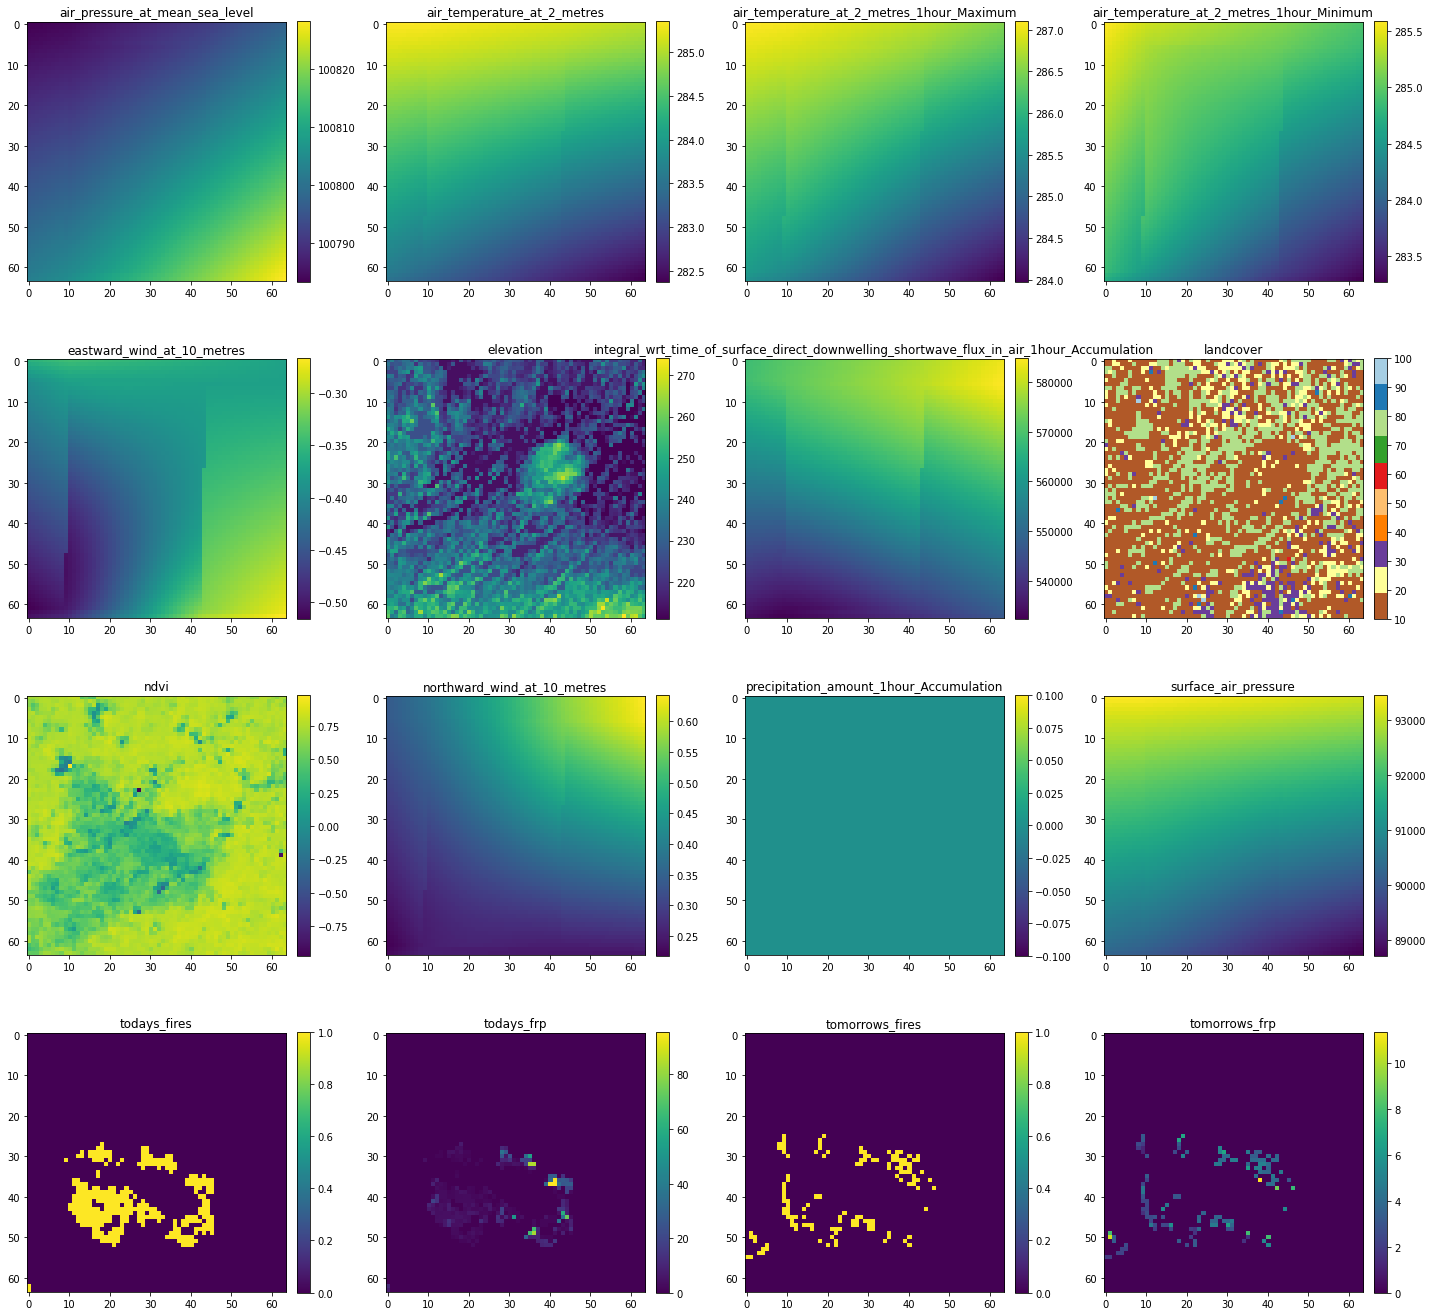

In [104]:
### Individual Example ###
horiz_no = 4
vert_no = 4
cmap = matplotlib.cm.get_cmap('Paired_r', 10)

figure, axis = plt.subplots(horiz_no, vert_no, figsize = (20,20), tight_layout=True)
for i in range(1, int(horiz_no*vert_no)+1):
    plt.subplot(4,4,i)
    
    if i == 8:
        plt.imshow(all_data[100,i-1], cmap = cmap)
    else:
        plt.imshow(all_data[100,i-1])
        
    plt.title(names_of_params[i-1])
    plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('figures/example1.png', dpi=250)

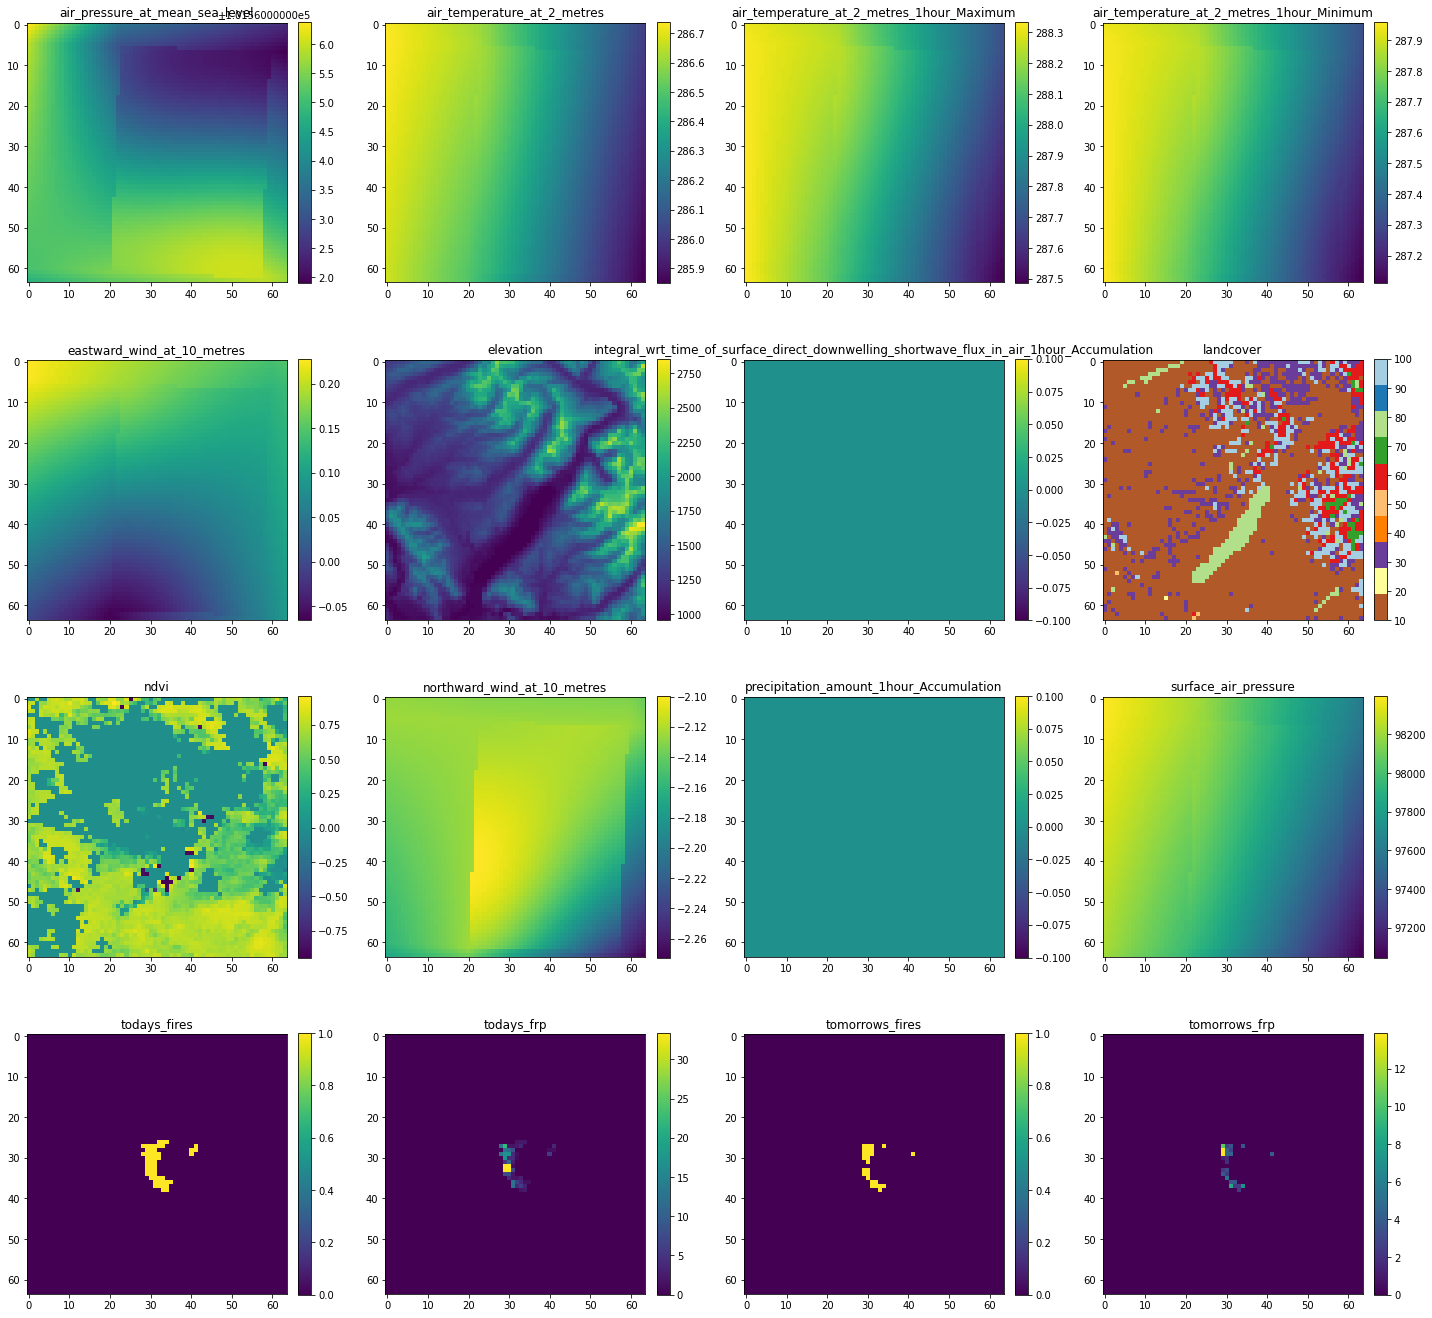

In [105]:
### Individual Example ###
horiz_no = 4
vert_no = 4
cmap = matplotlib.cm.get_cmap('Paired_r', 10)

figure, axis = plt.subplots(horiz_no, vert_no, figsize = (20,20), tight_layout=True)
for i in range(1, int(horiz_no*vert_no)+1):
    plt.subplot(4,4,i)
    
    if i == 8:
        plt.imshow(all_data[2000,i-1], cmap = cmap)
    else:
        plt.imshow(all_data[2000,i-1])
        
    plt.title(names_of_params[i-1])
    plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('figures/example2.png', dpi=250)

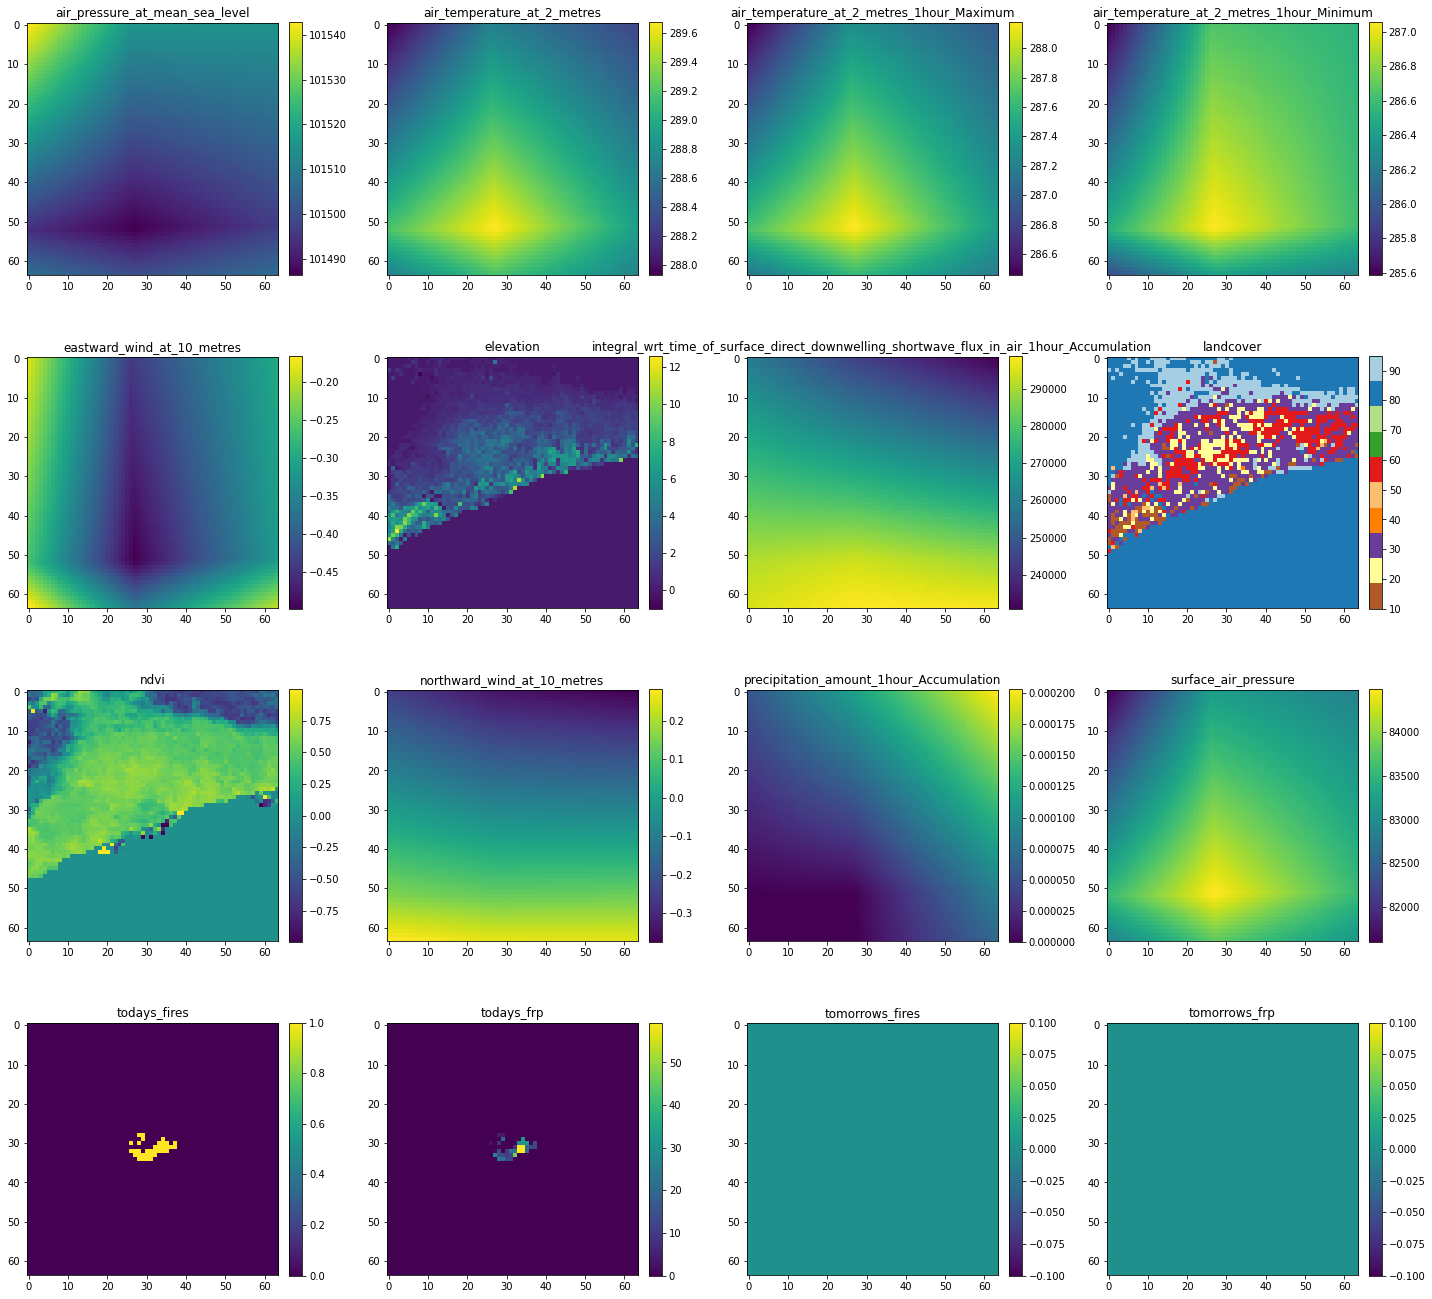

In [106]:
### Individual Example ###
horiz_no = 4
vert_no = 4
cmap = matplotlib.cm.get_cmap('Paired_r', 10)

figure, axis = plt.subplots(horiz_no, vert_no, figsize = (20,20), tight_layout=True)
for i in range(1, int(horiz_no*vert_no)+1):
    plt.subplot(4,4,i)
    
    if i == 8:
        plt.imshow(all_data[4500,i-1], cmap = cmap)
    else:
        plt.imshow(all_data[4500,i-1])
        
    plt.title(names_of_params[i-1])
    plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('figures/example3.png', dpi=250)

# Plot Today and Tomorrow Firemask Comparison

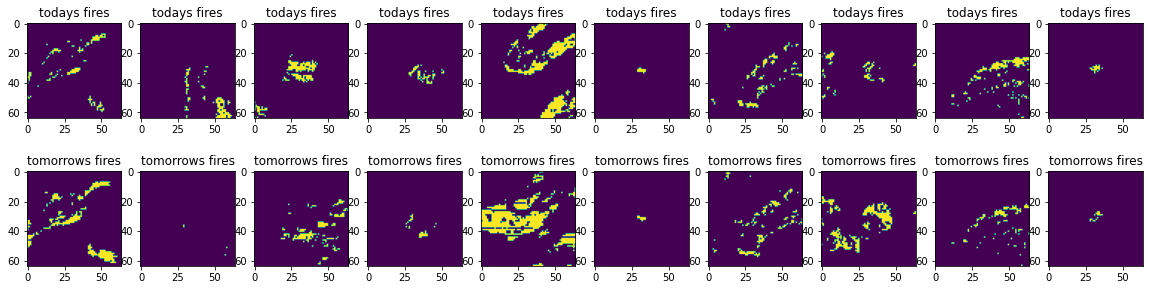

In [107]:
### Mean for Each Parameter ###
#rom pylab import *
horiz_no = 10
vert_no = 2
ticks = np.arange(0,2)

randoms = [random.randint(0,len(all_data)) for i in range(10)]
figure, axis = plt.subplots(horiz_no, vert_no, figsize = (20,5))

for i in range(1,11):
    plt.subplot(2,10,i)
    plt.title('todays fires')
    plt.imshow(all_data[randoms[i-1], -4])

for i in range(1,11):
    plt.subplot(2,10,i+10)
    plt.title('tomorrows fires')
    plt.imshow(all_data[randoms[i-1], -2])

plt.savefig('figures/today_tomorrow_fire.png')

# Plot Land Cover and NDVI Comparison

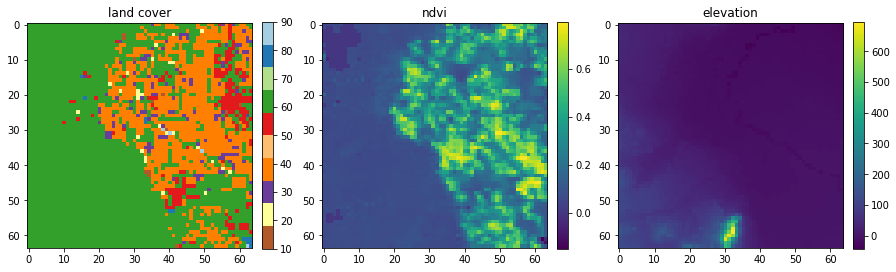

In [110]:
i = 4328
discrete_ndvi = np.digitize(all_data[i,11], bins = [-1, 0, 1])
plt.subplots(3, 1, figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(all_data[i, 7], cmap = cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('land cover')
plt.subplot(1,3,2)
plt.imshow(all_data[i, 8])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('ndvi')
plt.subplot(1,3,3)
plt.imshow(all_data[i,5])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('elevation')
plt.savefig('figures/land_ndvi_comp.png')